<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Localization in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

In [1]:
# Libraries/Packages Used:
import pandas as pd                        # For data manipulation and analysis.
import numpy as np                         # For numerical computations and handling arrays.
import math                                # For mathematical functions.
import itertools                           # To cycle through general iterables.
from itertools import cycle                # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt            # For creating static visualizations.
from matplotlib.lines import Line2D        # For creating custom lines in legends.
from matplotlib.patches import Patch       # For creating custom legend patches (e.g., colored boxes).
import seaborn as sns                      # For statistical data visualization based on matplotlib.
from plotly.subplots import make_subplots  # For creating interactive subplots.

import plotly.io as pio                    # For configuring plotly rendering behavior.
pio.renderers.default = 'jupyterlab'       # Set default Plotly renderer to JupyterLab.
%matplotlib inline

In [2]:
# Read data from the local CSV file
new_df = pd.read_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_combined_measurements_data.csv', low_memory=False)

# Print the info about the filtered DataFrame
print("\nInfo of Filtered DataFrame:\n")
new_df.info()


Info of Filtered DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4595276 entries, 0 to 4595275
Data columns (total 96 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   correlation_ids_0                                        object 
 1   device_id                                                object 
 2   end_device_ids_application_ids_application_id            object 
 3   end_device_ids_dev_addr                                  object 
 4   end_device_ids_dev_eui                                   object 
 5   end_device_ids_device_id                                 object 
 6   end_device_ids_join_eui                                  int64  
 7   received_at                                              object 
 8   time                                                     object 
 9   uplink_message_confirmed                                 bool   
 10  uplink_messa

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe, i.e. keeping important columns, mapping necessary info too.
</p>

In [3]:
# Columns to keep
columns_to_keep = {
    "time": "time",
    "gateway_id": "gateway",
    "end_device_ids_device_id": "device_id",
    "uplink_message_decoded_payload_co2": "co2",
    "uplink_message_decoded_payload_humidity": "humidity",
    "uplink_message_decoded_payload_pm25": "pm25",
    "uplink_message_decoded_payload_pressure": "pressure",
    "uplink_message_decoded_payload_temperature": "temperature",
    "uplink_message_rx_metadata_0_rssi": "rssi",
    "uplink_message_rx_metadata_0_snr": "snr",
    "uplink_message_settings_data_rate_lora_spreading_factor": "SF",
    "uplink_message_settings_frequency": "frequency",
    "uplink_message_f_cnt": "f_count",
    "uplink_message_decoded_payload_packetCount": "p_count",
    "uplink_message_consumed_airtime": "toa",
}

cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)
cleaned_df = cleaned_df[cleaned_df["device_id"] != "pilotdevice06"]

# Maps
distance_map_long = {
    "pilotdevice": 10,
    "pilotdevice01": 8,
    "pilotdevice02": 23,
    "pilotdevice03": 18,
    "pilotdevice04": 37,
    "pilotdevice05": 40,
}
wall_counts_map = {
    "pilotdevice": (0, 0),
    "pilotdevice01": (1, 0),
    "pilotdevice02": (0, 2),
    "pilotdevice03": (1, 2),
    "pilotdevice04": (0, 5),
    "pilotdevice05": (2, 2),
}
device_name_map = {
    "pilotdevice": "ED0",
    "pilotdevice01": "ED1",
    "pilotdevice02": "ED2",
    "pilotdevice03": "ED3",
    "pilotdevice04": "ED4",
    "pilotdevice05": "ED5",
}
gateway_name_map = {
    "kerlink001": "GW0",
    "eui-a84041ffff22dea4": "GW1",
    "eui-a84041ffff22def8": "GW2",
}

# Walls while IDs are still long-form (GW0-only scope)
cleaned_df[["c_walls_gw0", "w_walls_gw0"]] = cleaned_df["device_id"].map(wall_counts_map).apply(pd.Series)

# Rename device and gateway
cleaned_df["device_id"] = cleaned_df["device_id"].map(device_name_map)
cleaned_df["gateway"] = cleaned_df["gateway"].map(gateway_name_map).fillna(cleaned_df["gateway"])

# Distance to GW0 only
distance_map_short = {
    "ED0": 10,
    "ED1": 8,
    "ED2": 23,
    "ED3": 18,
    "ED4": 37,
    "ED5": 40,
}
cleaned_df["distance_gw0"] = cleaned_df["device_id"].map(distance_map_short)
cleaned_df.loc[cleaned_df["gateway"] != "GW0", "distance_gw0"] = np.nan
cleaned_df.loc[cleaned_df["gateway"] != "GW0", ["c_walls_gw0", "w_walls_gw0"]] = np.nan

# Numeric conversions
cleaned_df["frequency"] = pd.to_numeric(cleaned_df["frequency"], errors="coerce") / 1e6  # Hz -> MHz
cleaned_df["toa"] = cleaned_df["toa"].astype(str).str.rstrip("s").astype(float)
cleaned_df["SF"] = cleaned_df["SF"].astype("int64")

# Path loss (GW0 only) and power metrics
offset_gw0 = 14 - 0.14 + 0.4 + 3  # 17.26 dB
cleaned_df = cleaned_df.assign(
    exp_pl_gw0=np.where(cleaned_df["gateway"] == "GW0", offset_gw0 - cleaned_df["rssi"], np.nan),
    n_power=cleaned_df["rssi"] - 10 * np.log10(np.power(10, cleaned_df["snr"] / 10) + 1),
    esp=lambda d: d["n_power"] + d["snr"],
)

cleaned_df.to_csv("../LoRaWAN Localization - Advanced Files/all3_gateways_aggregated_measurements_data.csv", index=False)
cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
Index: 4595253 entries, 0 to 4595263
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          object 
 1   gateway       object 
 2   device_id     object 
 3   co2           float64
 4   humidity      float64
 5   pm25          float64
 6   pressure      float64
 7   temperature   float64
 8   rssi          float64
 9   snr           float64
 10  SF            int64  
 11  frequency     float64
 12  f_count       float64
 13  p_count       float64
 14  toa           float64
 15  c_walls_gw0   float64
 16  w_walls_gw0   float64
 17  distance_gw0  float64
 18  exp_pl_gw0    float64
 19  n_power       float64
 20  esp           float64
dtypes: float64(17), int64(1), object(3)
memory usage: 771.3+ MB


,time,gateway,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,...,frequency,f_count,p_count,toa,c_walls_gw0,w_walls_gw0,distance_gw0,exp_pl_gw0,n_power,esp
0,2024-10-01 00:00:25.147365+00:00,GW1,ED0,446.0,42.71,0.47,313.25,20.74,-50.0,12.5,...,867.9,5892.0,6638.0,0.987136,NaN,NaN,NaN,NaN,-62.737602,-50.237602
1,2024-10-01 00:22:27.032554+00:00,GW1,ED0,460.0,42.72,0.33,313.40,20.72,-120.0,-18.8,...,867.7,5914.0,6660.0,1.810432,NaN,NaN,NaN,NaN,-120.056877,-138.856877
2,2024-10-01 00:23:27.078821+00:00,GW1,ED0,458.0,42.69,0.57,313.39,20.74,-118.0,-18.5,...,868.3,5915.0,6661.0,1.810432,NaN,NaN,NaN,NaN,-118.060916,-136.560916
3,2024-10-01 00:25:28.129948+00:00,GW1,ED0,459.0,42.73,0.52,313.36,20.74,-120.0,-22.5,...,867.9,5916.0,6662.0,1.810432,NaN,NaN,NaN,NaN,-120.024354,-142.524354
4,2024-10-01 00:33:26.135224+00:00,GW1,ED0,452.0,42.74,0.34,313.48,20.73,-119.0,-17.8,...,867.3,5923.0,6671.0,0.452608,NaN,NaN,NaN,NaN,-119.071483,-136.871483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595259,2025-09-30 23:55:54.424694+00:00,GW0,ED5,487.0,46.39,2.80,331.89,22.50,-96.0,12.5,...,868.3,127143.0,127510.0,0.246784,2.0,2.0,40.0,113.26,-108.737602,-96.237602
4595260,2025-09-30 23:56:54.475849+00:00,GW0,ED5,492.0,46.32,2.87,331.88,22.51,-96.0,11.5,...,868.1,127144.0,127511.0,0.246784,2.0,2.0,40.0,113.26,-107.797062,-96.297062
4595261,2025-09-30 23:57:54.522181+00:00,GW0,ED5,495.0,46.33,2.84,331.87,22.50,-96.0,11.8,...,867.7,127145.0,127512.0,0.246784,2.0,2.0,40.0,113.26,-108.077855,-96.277855
4595262,2025-09-30 23:58:54.575768+00:00,GW0,ED5,495.0,46.35,3.07,331.91,22.49,-98.0,11.5,...,867.1,127146.0,127513.0,0.246784,2.0,2.0,40.0,115.26,-109.797062,-98.297062


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking (abnormal) Anomalies with BOX PLOTS
</p>

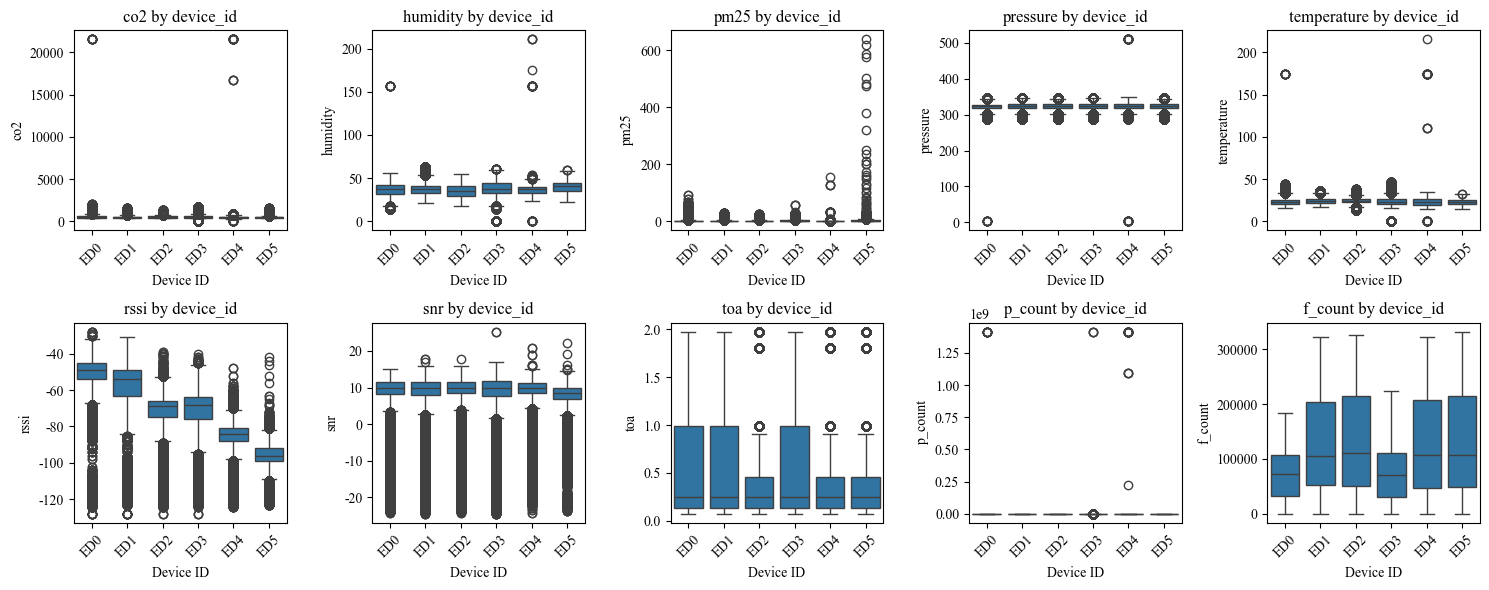

In [4]:
# Columns to plot
plot_cols = ["co2", "humidity", "pm25", "pressure", "temperature", "rssi", "snr", "toa",'p_count', 'f_count']  

# Device order
desired_order = ["ED0", "ED1", "ED2", "ED3", "ED4", "ED5"]

cleaned_df = cleaned_df.copy()
cleaned_df["device_id"] = pd.Categorical(cleaned_df["device_id"], categories=desired_order, ordered=True)

cols = 5
rows = math.ceil(len(plot_cols) / cols)
plt.figure(figsize=(cols * 3, rows * 3))

for idx, col in enumerate(plot_cols, 1):
    if col not in cleaned_df.columns:
        continue
    plt.subplot(rows, cols, idx)
    sns.boxplot(x="device_id", y=col, data=cleaned_df, order=desired_order)
    plt.title(f"{col} by device_id")
    plt.xlabel("Device ID")
    plt.ylabel(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [5]:
start_date = pd.Timestamp('2025-07-05', tz='UTC')
time_utc = pd.to_datetime(cleaned_df['time'], utc=True)

all_gw_df = cleaned_df[
    (time_utc >= start_date) &
    (cleaned_df['p_count'] <= 2_000_000)
]

pdr_table = (
    all_gw_df
    .groupby('device_id', observed=True)  # observed=True silences the warning
    .agg(total_sent_packets=('p_count', 'max'),
         received_packets=('f_count', 'max'))
)
pdr_table['PDR (%)'] = (
    pdr_table['received_packets'] / pdr_table['total_sent_packets'] * 100
)
pdr_table

,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,127511.0,127215.0,99.767863
ED1,127506.0,127208.0,99.766286
ED2,127523.0,127238.0,99.776511
ED3,117586.0,117189.0,99.662375
ED4,127512.0,126741.0,99.395351
ED5,127514.0,127147.0,99.712188


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [6]:
# Remove rows with a temperature above 80
cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 80)]

# Remove rows with humidity below 100
cleaned_df = cleaned_df[~(cleaned_df['humidity'] > 100)]

# Remove rows with a CO2 above 5000
cleaned_df = cleaned_df[~(cleaned_df['co2'] > 5000)]

# Remove rows with a CO2 = 0
cleaned_df = cleaned_df[~(cleaned_df['co2'] == 0)]

# Save all data to csv
cleaned_df.to_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 4595033 entries, 0 to 4595263
Data columns (total 21 columns):
 #   Column        Dtype   
---  ------        -----   
 0   time          object  
 1   gateway       object  
 2   device_id     category
 3   co2           float64 
 4   humidity      float64 
 5   pm25          float64 
 6   pressure      float64 
 7   temperature   float64 
 8   rssi          float64 
 9   snr           float64 
 10  SF            int64   
 11  frequency     float64 
 12  f_count       float64 
 13  p_count       float64 
 14  toa           float64 
 15  c_walls_gw0   float64 
 16  w_walls_gw0   float64 
 17  distance_gw0  float64 
 18  exp_pl_gw0    float64 
 19  n_power       float64 
 20  esp           float64 
dtypes: category(1), float64(17), int64(1), object(2)
memory usage: 740.6+ MB


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
   BOX PLOTS after physical elimination of 'abnormal' anomalies
</p>

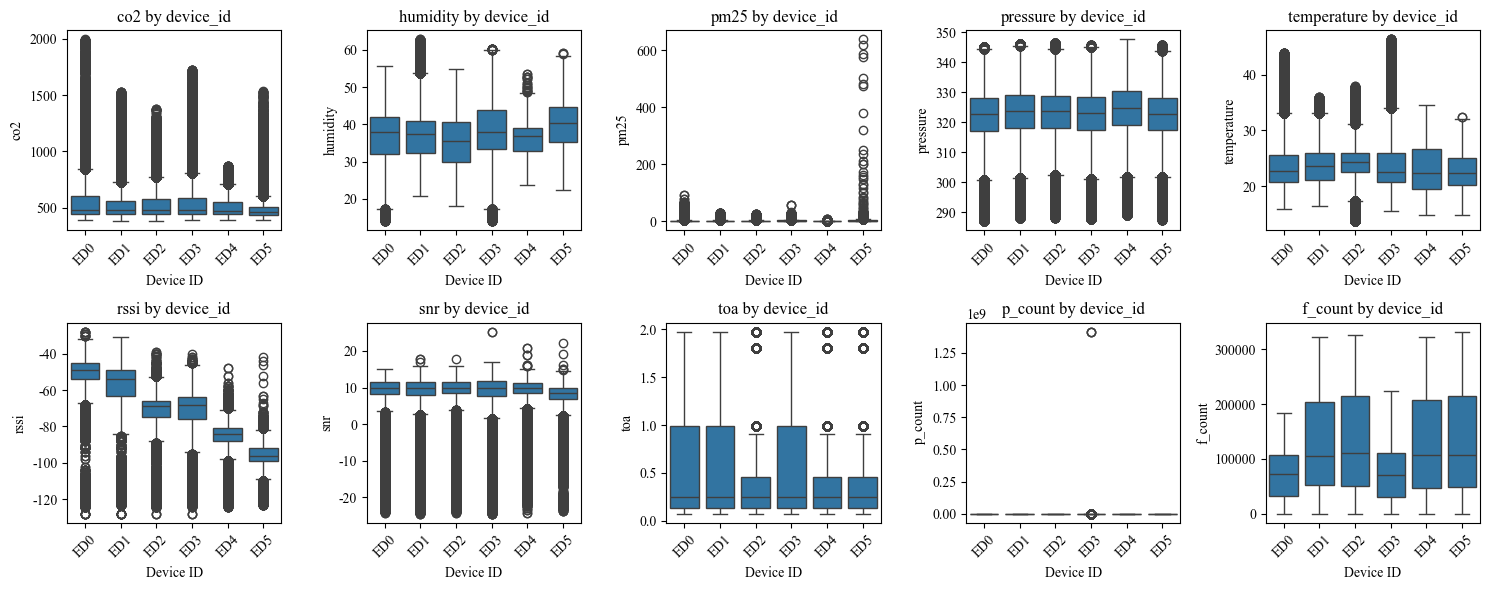

In [7]:
# Columns to plot
plot_cols = ["co2", "humidity", "pm25", "pressure", "temperature", "rssi", "snr", "toa",'p_count', 'f_count']  

# Device order
desired_order = ["ED0", "ED1", "ED2", "ED3", "ED4", "ED5"]

cleaned_df = cleaned_df.copy()
cleaned_df["device_id"] = pd.Categorical(cleaned_df["device_id"], categories=desired_order, ordered=True)

cols = 5
rows = math.ceil(len(plot_cols) / cols)
plt.figure(figsize=(cols * 3, rows * 3))

for idx, col in enumerate(plot_cols, 1):
    if col not in cleaned_df.columns:
        continue
    plt.subplot(rows, cols, idx)
    sns.boxplot(x="device_id", y=col, data=cleaned_df, order=desired_order)
    plt.title(f"{col} by device_id")
    plt.xlabel("Device ID")
    plt.ylabel(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [8]:
# Generate statistical description and remove unnecessary columns
stat_description = cleaned_df.describe().transpose().drop(
    columns=['count']).drop(['f_count', 'p_count'])

# Define the exact order of metrics and units for alignment
metrics = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature', 
    'rssi', 'snr', 'SF', 'frequency', 'toa', 
    'distance_gw0', 'c_walls_gw0', 'w_walls_gw0', 'exp_pl_gw0', 'n_power', 'esp'
]
units = [
    'ppm', '%', 'µg/m³', 'hPa', '°C', 'dBm', 'dB', 'bit/sym', 'MHz', 's', 
    'm', '', '', 'dB', 'dB', 'dBm'
]

# Set index explicitly to ensure correct row order
stat_description = stat_description.loc[metrics]

# Add units as a separate column
stat_description.insert(0, 'Unit', units)

# Rename columns accordingly
stat_description = stat_description.rename(columns={
    'mean': 'Mean',
    'std': 'STD (σ)',
    'min': 'Min',
    '25%': '1ˢᵗ Quartile (25%)', 
    '50%': 'Median', 
    '75%': '3ʳᵈ Quartile (75%)',
    'max': 'Max'
})

# Add "Field" as a regular column to align with other columns
stat_description.reset_index(inplace=True)
stat_description = stat_description.rename(columns={'index': 'Field'})

# Remove the automatic index numbering in the output
stat_description.index = [''] * len(stat_description)

# Format floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save to Excel file without automatic indices
excel_path = "all3_gateways_statistical_description.xlsx"
stat_description.to_excel(excel_path, index=False)

# Display the updated statistical description
stat_description

,Field,Unit,Mean,STD (σ),Min,1ˢᵗ Quartile (25%),Median,3ʳᵈ Quartile (75%),Max
,co2,ppm,524.224,123.714,381.000,443.000,477.000,566.000,1993.000
,humidity,%,37.279,6.509,13.960,32.580,37.490,41.560,62.810
,pm25,µg/m³,2.038,2.423,0.000,0.670,1.310,2.500,637.710
,pressure,hPa,322.818,8.676,286.910,317.760,323.410,328.730,347.570
,temperature,°C,23.563,3.695,13.740,20.900,23.050,25.980,46.290
,rssi,dBm,-74.751,23.658,-128.000,-89.000,-69.000,-56.000,-28.000
,snr,dB,7.202,7.714,-24.500,8.000,9.800,11.500,25.200
,SF,bit/sym,9.292,1.627,7.000,8.000,9.000,10.000,12.000
,frequency,MHz,867.823,0.462,867.100,867.500,867.900,868.300,868.500
,toa,s,0.528,0.566,0.072,0.134,0.247,0.494,1.974


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

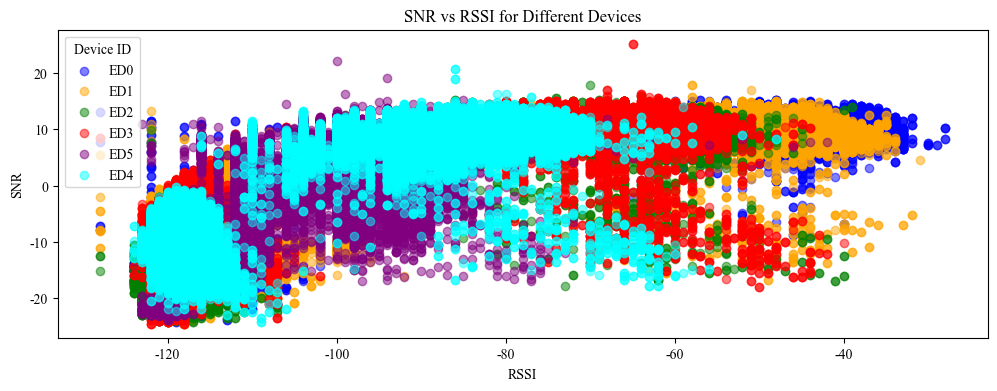

In [9]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color, alpha=0.5)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID', loc='upper left')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)

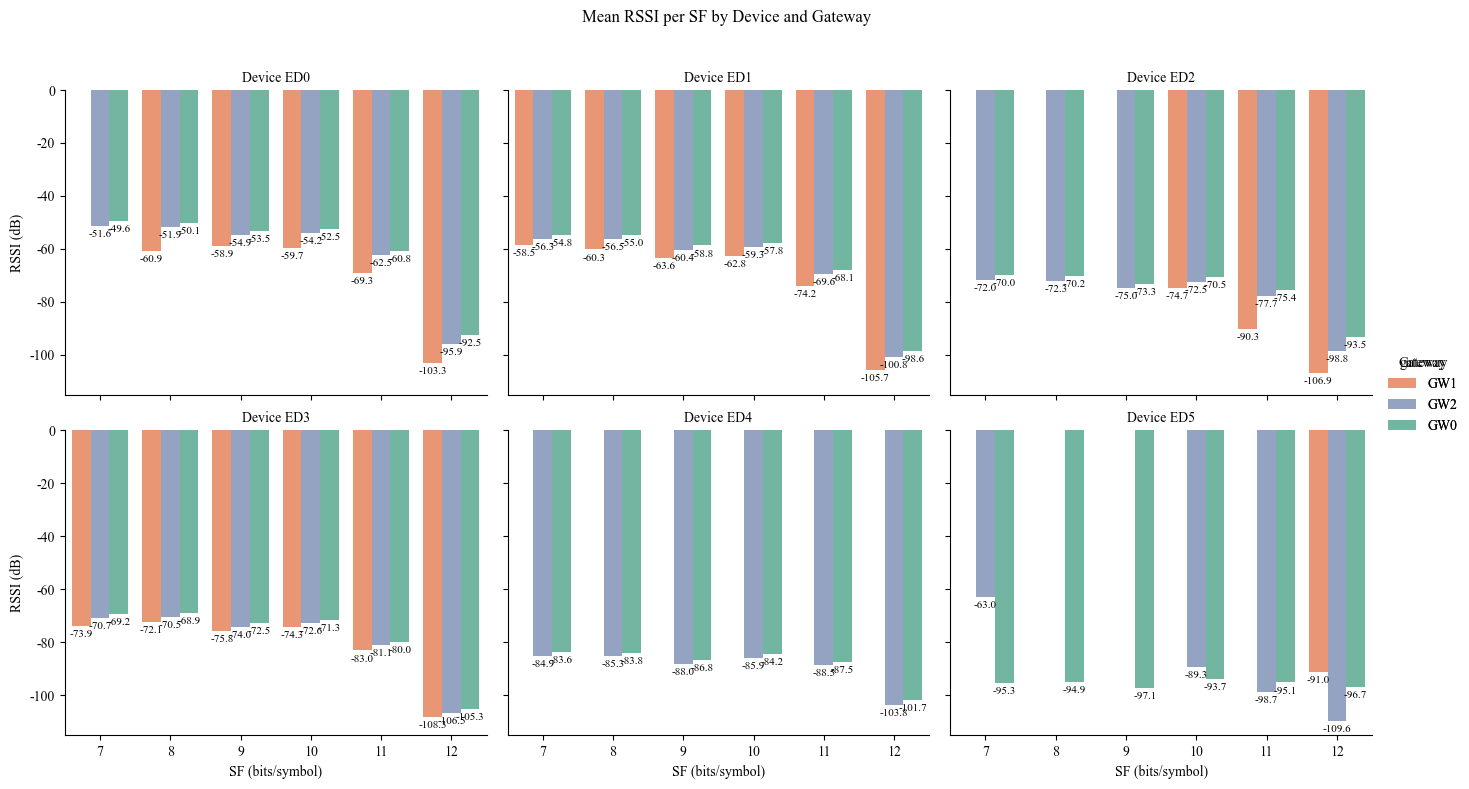

In [10]:
devices = sorted(cleaned_df['device_id'].unique())  # 6 devices
sf_order = sorted(cleaned_df['SF'].unique())
gateways = sorted(cleaned_df['gateway'].unique())
palette = dict(zip(gateways, sns.color_palette("Set2", n_colors=len(gateways))))

g = sns.catplot(
    data=cleaned_df,
    kind='bar',
    x='SF', y='rssi',
    hue='gateway',
    col='device_id', col_wrap=3,  # 2 rows × 3 cols
    order=sf_order,
    palette=palette,
    estimator='mean', errorbar=None,
    sharey=True,
    height=4, aspect=1.1
)

for ax in g.axes.flatten():
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', padding=2, fontsize=8)
    ax.set_xlabel('SF (bits/symbol)')
    ax.set_ylabel('RSSI (dB)')

g.set_titles('Device {col_name}')
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Mean RSSI per SF by Device and Gateway')
g.add_legend(title='Gateway')
plt.show()

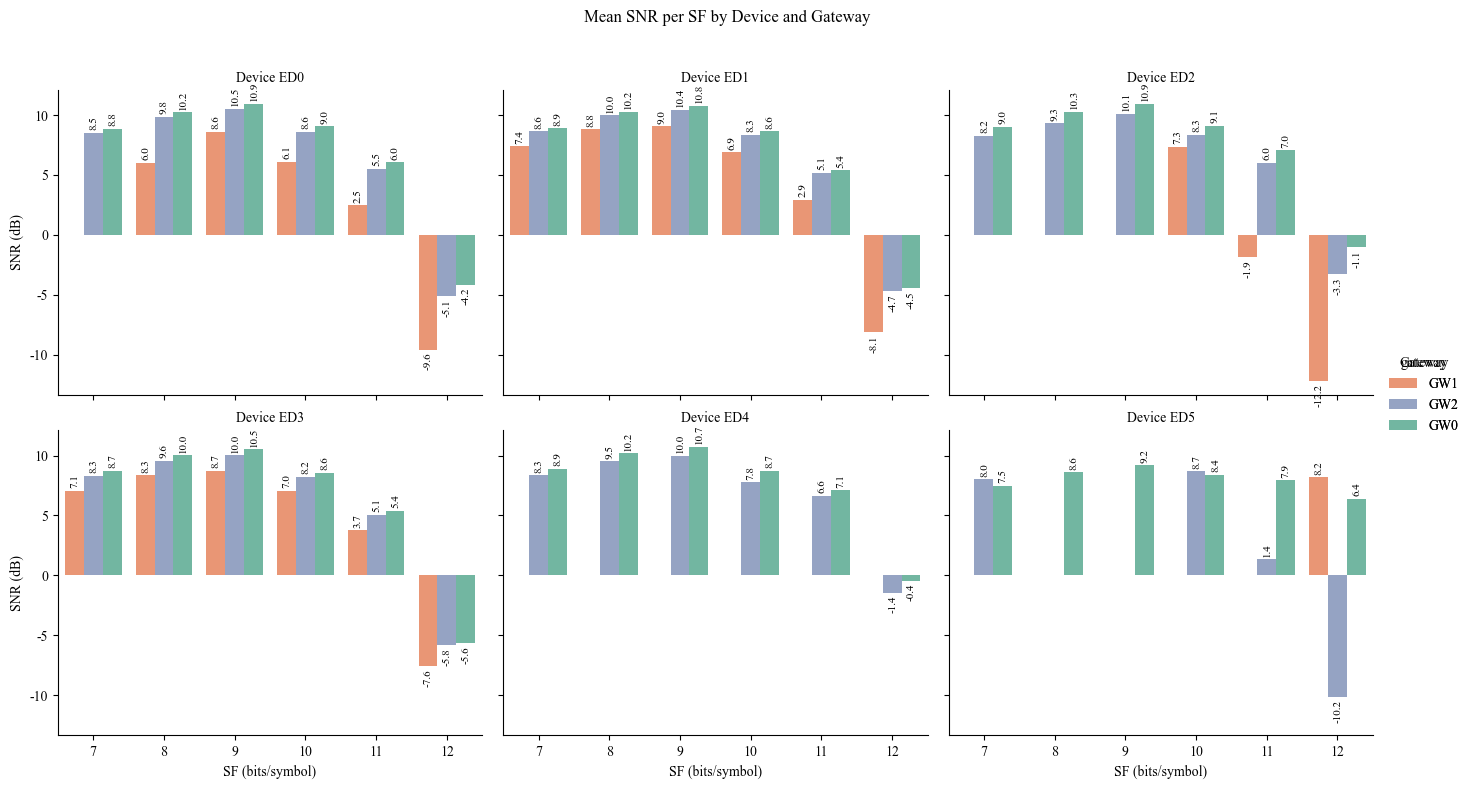

In [11]:
g = sns.catplot(
    data=cleaned_df,
    kind='bar',
    x='SF', y='snr',
    hue='gateway',
    col='device_id', col_wrap=3,
    order=sf_order,
    palette=palette,
    estimator='mean', errorbar=None,
    sharey=True,
    height=4, aspect=1.1
)

for ax in g.axes.flatten():
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', padding=2, fontsize=8, rotation=90)
    ax.set_xlabel('SF (bits/symbol)')
    ax.set_ylabel('SNR (dB)')

g.set_titles('Device {col_name}')
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Mean SNR per SF by Device and Gateway')
g.add_legend(title='Gateway')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

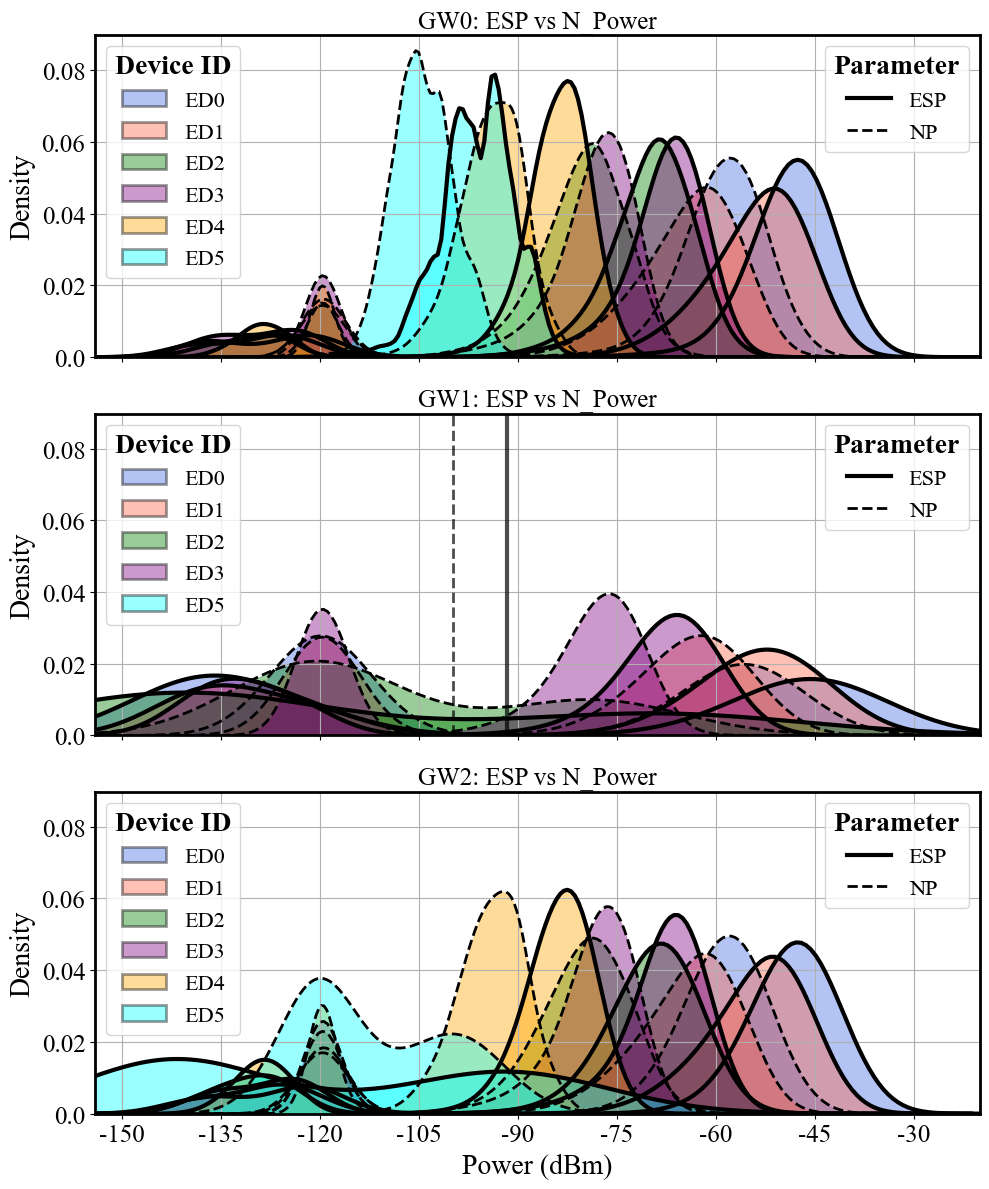

In [12]:
def plot_esp_n_power_comparison(ax, data, colors, bw_adjust=2, title=''):
    devices = sorted(data['device_id'].unique())
    for device in devices:
        subset = data[data['device_id'] == device]

        # ESP
        if subset['esp'].nunique() > 1:
            sns.kdeplot(subset['esp'], ax=ax, lw=0, bw_adjust=bw_adjust,
                        color=colors[device], fill=True, alpha=0.4, label=None)
            sns.kdeplot(subset['esp'], ax=ax, lw=3, bw_adjust=bw_adjust,
                        color='black', linestyle='-', fill=False, label=f'{device} - ESP')
        else:
            val = subset['esp'].iloc[0]
            ax.axvline(val, color='black', linestyle='-', linewidth=3, alpha=0.7, label=f'{device} - ESP')

        # N_Power
        if subset['n_power'].nunique() > 1:
            sns.kdeplot(subset['n_power'], ax=ax, lw=0, bw_adjust=bw_adjust,
                        color=colors[device], fill=True, alpha=0.4, label=None)
            sns.kdeplot(subset['n_power'], ax=ax, lw=2, bw_adjust=bw_adjust,
                        color='black', linestyle='--', fill=False, label=f'{device} - N_Power')
        else:
            val = subset['n_power'].iloc[0]
            ax.axvline(val, color='black', linestyle='--', linewidth=2, alpha=0.7, label=f'{device} - N_Power')

    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Power (dBm)', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.grid(True)
    ax.set_xticks(range(-150, -19, 15))
    ax.set_xticklabels(range(-150, -19, 15), fontsize=18)
    ax.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08])
    ax.set_yticklabels(['0.0', '0.02', '0.04', '0.06', '0.08'], fontsize=18)
    ax.set_xlim(-154, -20)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    device_handles = [Patch(facecolor=colors[d], alpha=0.4, edgecolor='black', linewidth=2) for d in devices]
    parameter_handles = [
        Line2D([0], [0], color='black', lw=3, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    legend1 = ax.legend(device_handles, devices, title='Device ID',
                        loc='upper left', fontsize=16, title_fontsize=20)
    legend1.get_title().set_fontweight('bold')
    ax.add_artist(legend1)
    legend2 = ax.legend(parameter_handles, ['ESP', 'NP'], title='Parameter',
                        loc='upper right', fontsize=16, title_fontsize=20)
    legend2.get_title().set_fontweight('bold')
# consistent colors across all devices
all_devices = sorted(cleaned_df['device_id'].unique())
color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange',
                    'cyan', 'magenta', 'brown', 'olive', 'pink'])
colors = {d: next(color_pool) for d in all_devices}

gateways = ['GW0', 'GW1', 'GW2']  # adjust if your IDs differ
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True, sharey=True)

for ax, gw in zip(axes, gateways):
    gw_df = cleaned_df[cleaned_df['gateway'] == gw]
    plot_esp_n_power_comparison(ax, gw_df, colors, bw_adjust=2, title=f'{gw}: ESP vs N_Power')

plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 .....................#........................
</p>